In [1]:
import pandas as pd
point = pd.read_parquet('./material/soc.topsoil_organized.pq')
series = pd.read_parquet('./material/time.series_lucas_plausible.pq')

## organize lucas soc time series

In [6]:
dfs = df
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi_p50',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi_p50'}
            # 'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndvi_slope',
            # 'ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndwi_slope'}

dfs = dfs.rename(columns = name_map)
            
for col in ['ndvi_p50','ndwi_p50']:
    dfs[col] = (dfs[col]-125)/125

In [8]:
from skmap.misc import TimeTracker, ttprint

lid = dfs.groupby('id').filter(lambda x: len(x) > 1)['id'].unique().tolist() # only focus on 3-pnt series
ttprint('start organizing')
data_list = []

for iid in lid:
    temp = dfs.loc[dfs['id'] == iid].sort_values(by=['time'])  

    static_vals = temp.iloc[0][scol].tolist()  # Extract static values once

    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

tcol = ['lat', 'lon', 'time', 'soc', 'lc_survey', 'ndvi_p50', 'ndwi_p50'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep'] # static cols
tsdf = pd.DataFrame(data_list, columns=scol + [i + '_pair' for i in tcol])
ttprint('finish organizing')

[13:26:17] start organizing
[13:28:27] finish organizing


In [9]:
tsdf.to_csv('./material/soc_delta.pair_lucas.csv',index=False)

## filter delta pairs

In [47]:
tsdf['soc_delta'] = tsdf['soc_pair'].str[1] - tsdf['soc_pair'].str[0]
tsdf['time_delta'] = tsdf['time_pair'].str[1] - tsdf['time_pair'].str[0]

tsdf['lc_delta'] = tsdf['lc_survey_pair'].str[0].str[0] != tsdf['lc_survey_pair'].str[1].str[0]
tsdf['soc_rate'] = tsdf['soc_delta'] / tsdf['time_delta']

tsdf['quality'] = 1
tsdf.loc[tsdf['soc_rate'].abs() > 0.5, 'quality'] = 0 


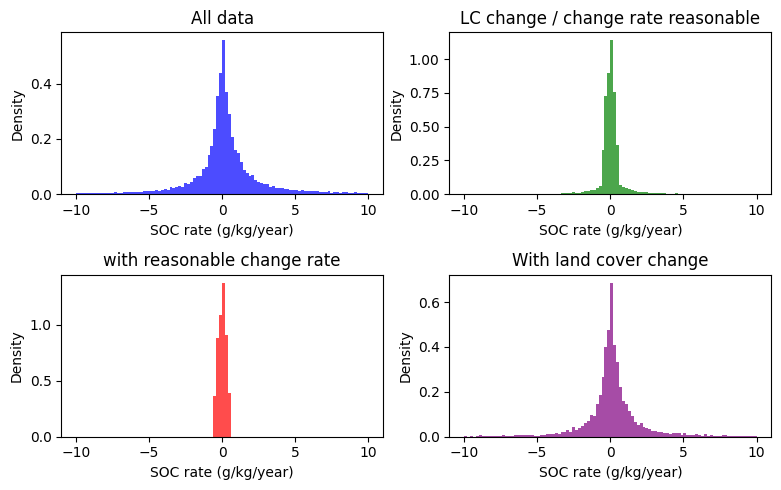

In [49]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(tsdf["soc_rate"], bins=100, range=[-10,10], alpha=0.7, color="blue", density=True)
axes[0, 0].set_title("All data")
axes[0, 0].set_xlabel("SOC rate (g/kg/year)")
axes[0, 0].set_ylabel("Density")

axes[0, 1].hist(tsdf.loc[(tsdf['lc_delta']==1) | (tsdf['quality']==1),'soc_rate'], bins=100, range=[-10,10],alpha=0.7, color="green", density=True)
axes[0, 1].set_title("LC change / change rate reasonable")
axes[0, 1].set_xlabel("SOC rate (g/kg/year)")
axes[0, 1].set_ylabel("Density")

axes[1, 0].hist(tsdf.loc[tsdf['quality']==1,'soc_rate'], bins=100, range=[-10,10],alpha=0.7, color="red", density=True)
axes[1, 0].set_title("with reasonable change rate")
axes[1, 0].set_xlabel("SOC rate (g/kg/year)")
axes[1, 0].set_ylabel("Density")

axes[1, 1].hist(tsdf.loc[(tsdf['lc_delta']==1),'soc_rate'], bins=100, range=[-10,10],alpha=0.7, color="purple", density=True)
axes[1, 1].set_title("With land cover change")
axes[1, 1].set_xlabel("SOC rate (g/kg/year)")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()